In [1]:
import numpy as np
import pandas as pd
import os, shutil, re, pickle

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras import backend as K

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


### Importing and formatting data

#### Import image data

I started the modeling process by importing the image pixel data that I had already converted to a binary form in the first notebook:

In [16]:
with open('data/thresholded_imgs.pkl','rb') as f:
    imgs = pickle.load(f)

img_df = pd.DataFrame(imgs,columns=['file_id','pixels'])
img_df.head(2)

,file_id,pixels
0,833_06,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,317_04,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


I added a column for the original letter id to use to merge later.

In [17]:
img_df['let_id'] = img_df.file_id.apply(lambda x: x.split('_')[0])
img_df.head(2)

,file_id,pixels,let_id
0,833_06,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",833
1,317_04,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",317


#### Train/test split

I did a train/test split, using the pixel data as the X features and the file_id identifier as the target y values.

In [22]:
X_train, X_test, y_train, y_test = \
    train_test_split((img_df['pixels']), img_df['file_id'], test_size=0.2, random_state=42)

X_train = np.stack(X_train.values)
X_test = np.stack(X_test.values)

X_train = X_train.reshape(len(X_train),256,256,1)
X_test = X_test.reshape(len(X_test),256,256,1)

#### Import info and NLP results for each letter

I then imported the data for each letter: recipient, date, and NLP sentiment analysis results.  merged that to the df with the pixel information.

In [5]:
letter_info = pd.read_pickle('data/letters_with_NLP_results.pkl')

letter_info = letter_info.merge(img_df[['let_id','file_id']],how='inner',on='let_id')

In [24]:
letter_info.head()

,let_id,recipient,place,word_count,avg_sent_length,year,to_theo,avg_sentiment,num_sent,perc_neg,perc_pos,file_id
0,001,Theo van Gogh,The Hague,118,17.428571,1872,1,0.068183,7,0.428571,0.428571,001_01
1,001a,Hendrik Verzijl,The Hague,123,14.555556,1872,0,0.413775,9,0.111111,0.333333,001a_02
2,001a,Hendrik Verzijl,The Hague,123,14.555556,1872,0,0.413775,9,0.111111,0.333333,001a_03
3,001a,Hendrik Verzijl,The Hague,123,14.555556,1872,0,0.413775,9,0.111111,0.333333,001a_01
4,002,Theo van Gogh,The Hague,145,14.363636,1872,1,0.560262,11,0.000000,0.727273,002_01


Then, I merged the test data back with the letter info to be used during analysis. 

In [25]:
y_test_info = pd.DataFrame(y_test,columns=['file_id']).merge(letter_info, how='left',on='file_id')

### Training the Convolutional Autoencoder

#### Building the neural network

In [26]:
input_img = Input(shape=(256,256,1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 8)         0         
__________

#### Training round 1 - 20 epochs

In [28]:
history = autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                verbose=True,
                validation_data=(X_test, X_test))

Instructions for updating:
Use tf.cast instead.
Train on 2821 samples, validate on 706 samples
Epoch 1/20
2821/2821 [==============================] - 306s 108ms/step - loss: 0.3915 - acc: 0.9110 - val_loss: 0.3284 - val_acc: 0.9124
Epoch 2/20
2821/2821 [==============================] - 297s 105ms/step - loss: 0.3199 - acc: 0.9121 - val_loss: 0.3308 - val_acc: 0.9124
Epoch 3/20
2821/2821 [==============================] - 291s 103ms/step - loss: 0.3133 - acc: 0.9121 - val_loss: 0.3093 - val_acc: 0.9124
Epoch 4/20
2821/2821 [==============================] - 305s 108ms/step - loss: 0.3045 - acc: 0.9121 - val_loss: 0.2980 - val_acc: 0.9124
Epoch 5/20
2821/2821 [==============================] - 293s 104ms/step - loss: 0.2961 - acc: 0.9121 - val_loss: 0.3019 - val_acc: 0.9124
Epoch 6/20
2821/2821 [==============================] - 299s 106ms/step - loss: 0.2929 - acc: 0.9121 - val_loss: 0.3337 - val_acc: 0.9124
Epoch 7/20
2821/2821 [==============================] - 297s 105ms/step - los

In [29]:
# autoencoder.save('data/model_20epochs.h5')

#### Training round 2 - 20 more epochs

In [ ]:
autoencoder = load_model('data/model_20epochs.h5')
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['acc'])

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                verbose=True,
                validation_data=(X_test, X_test))

In [ ]:
# autoencoder.save('data/model_40epochs.h5')

#### Training round 3 - 20 more epochs

In [ ]:
autoencoder = load_model('data/model_40epochs.h5')
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['acc'])

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                verbose=True,
                validation_data=(X_test, X_test))

In [ ]:
# autoencoder.save('data/model_60epochs.h5')

### Analysis

In [34]:
# load model
autoencoder = load_model('data/model_60epochs.h5')
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['acc'])

# decode test images
decoded_test = autoencoder.predict(X_test)

# function to get compressed vector representation
get_encoded_layer_output = K.function([autoencoder.layers[0].input],
                                  [autoencoder.layers[6].output])

# get compressed vectors for X_val
X_test_vector = get_encoded_layer_output([X_test])[0]
# reshaping to be (706,8192) instead of (706,32,32,8)
X_test_vector = X_test_vector.reshape(len(X_test_vector), (np.prod(X_test_vector.shape[1:])))

Now we can look at the original images along with the recreated image to get a visual gauge for how good the autoencoder is. 

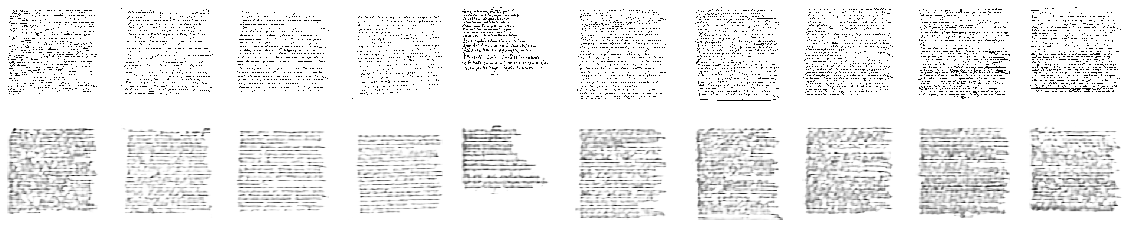

In [37]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i+60].reshape(256,256))
    plt.gray()
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i +1+ n)
    plt.imshow(decoded_test[i+60].reshape(256,256))
    plt.gray()
    plt.axis('off')
plt.show()

#### Further reducing compressed vector with PCA

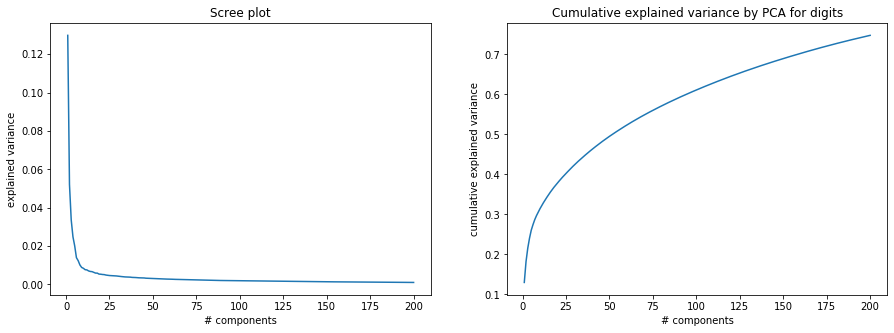

In [36]:
comp = 200
pca = PCA(n_components=comp)
pca.fit(X_test_vector)
pca_test = pca.transform(X_test_vector)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(1,comp+1),pca.explained_variance_ratio_)
plt.xlabel('# components')
plt.ylabel('explained variance')
plt.title('Scree plot')

plt.subplot(1,2,2)
plt.plot(range(1,comp+1),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# components')
plt.ylabel('cumulative explained variance');
plt.title('Cumulative explained variance by PCA for digits');

#### Using Kmeans to cluster the vectors

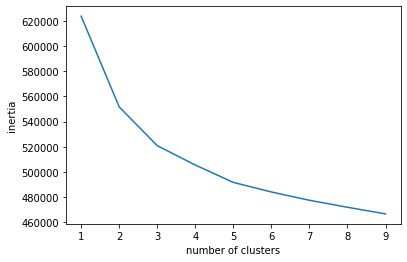

In [40]:
inertias = []
for i in range(1,10):
    km = KMeans(n_clusters=i)
    km.fit(pca_test)
    inertias.append(km.inertia_)

plt.plot(range(1,10),inertias)
plt.ylabel('inertia')
plt.xlabel('number of clusters');

In [42]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmykw'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

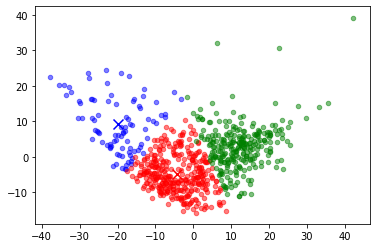

In [43]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(pca_test)
display_cluster(pca_test,km,num_clusters)

In [44]:
# labeling the y_test data with cluster assignments for the 3 clusters
y_test_info['cluster'] = km.labels_

In [50]:
y_test_info.sort_values(by='avg_sentiment', ascending=True).head(10)

,file_id,let_id,recipient,place,word_count,avg_sent_length,year,to_theo,avg_sentiment,num_sent,perc_neg,perc_pos,cluster
672,457_04,457,Theo van Gogh,Nuenen,639,36.105263,1884,1,-0.098194,19,0.473684,0.421053,1
11,540_01,540,Theo van Gogh,Nuenen,615,22.931034,1885,1,-0.091990,29,0.482759,0.241379,1
91,806_04,806,Theo van Gogh,Saint-Rémy-de-Provence,664,17.743590,1889,1,-0.041340,39,0.307692,0.333333,1
102,806_02,806,Theo van Gogh,Saint-Rémy-de-Provence,664,17.743590,1889,1,-0.041340,39,0.307692,0.333333,0
213,609_01,609,Theo van Gogh,Arles,387,19.714286,1888,1,-0.031714,21,0.285714,0.380952,1
211,401_04,401,Theo van Gogh,Nieuw-Amsterdam,2286,30.412500,1883,1,-0.029045,80,0.412500,0.362500,2
568,401_02,401,Theo van Gogh,Nieuw-Amsterdam,2286,30.412500,1883,1,-0.029045,80,0.412500,0.362500,2
193,198_01,198,Theo van Gogh,The Hague,319,17.200000,1882,1,-0.026710,20,0.200000,0.300000,1
583,195_01,195,Anthon van Rappard,The Hague,448,20.000000,1881,0,-0.024894,24,0.333333,0.416667,1
411,195_02,195,Anthon van Rappard,The Hague,448,20.000000,1881,0,-0.024894,24,0.333333,0.416667,0


In [51]:
# adding the first two PCA components to the dataframe to be used to plot in Tableau
y_test_info['pca1'] = pca_test[:,0]
y_test_info['pca2'] = pca_test[:,1]

In [52]:
y_test_info.to_csv('data/model_pca200_km3_results.csv')